In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def derivative_theta(theta, I):
  dtheta = np.zeros(N)
  dtheta += w + 2*L*I

  for i in range(N):
    for j in range(N):
      dtheta[i] += K[i][j] * np.sin(theta[j]-theta[i])* (2 * np.sqrt(I[i]*I[j]) - np.sqrt(I[j]/I[i]) * (I[j]-I[i]))
  return dtheta

def derivative_I(theta, I):
  dI = np.zeros(N)
  for i in range(N):
    for j in range(N):
      dI[i] += K[i][j] * np.sqrt(I[i]*I[j]) * (I[j]-I[i])* np.cos(theta[j]-theta[i])

  return -2.*dI

def Hamiltonian_function(theta, I):
  H = 0
  for i in range(N):
    H += w[i]*I[i] + L*I[i]*I[i]
    for j in range(N):
      H -= K[i][j] * np.sqrt(I[i]*I[j]) * (I[j]-I[i]) * np.sin(theta[j]-theta[i])
  return H


In [3]:
# Model parameters
N = 2
k11 = k22 = 0.
k12 = 1.
k21 = k12
K = np.array([[k11, k12],
              [k21, k22]])
L = 2. # 5.

w1 = 0.8 # 0.01
w2 = 0.1 # 10.
w = np.array([w1, w2])*2.0*np.pi


# Initial condition
theta0 = np.array([1.,-0.6])*np.pi # (1.1, -1.)
I0 = np.array([1.,0.2]) # (1.5, 0.2)

In [4]:
# Total time interval (start from t = 0)
T = 50

# time step
t_step = 0.001

n_steps = int(T/t_step)

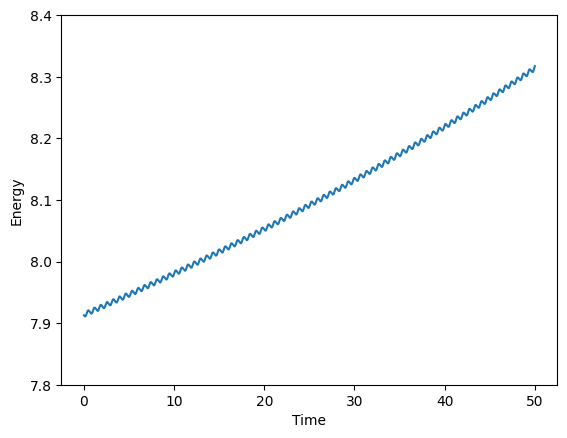

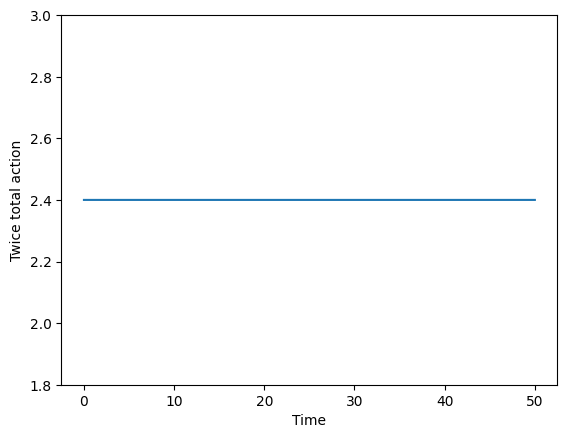

In [5]:
# Explicit Euler
theta_eE = np.zeros((n_steps, N))
I_eE = np.zeros((n_steps, N))

theta_eE[0][:] = theta0
I_eE[0][:] = I0

times = np.zeros(n_steps)
energies = np.zeros(n_steps)
C2s = np.zeros(n_steps)

energies[0] = Hamiltonian_function(theta_eE[0,:], I_eE[0,:])
C2s[0] = 2*np.sum(I_eE[0, :])
for n in range(0, n_steps-1):

  theta_eE[n+1, :] = theta_eE[n] + t_step * derivative_theta(theta_eE[n, :], I_eE[n, :])
  I_eE[n+1, :] = I_eE[n, :] + t_step * derivative_I(theta_eE[n, :], I_eE[n, :])

  times[n+1] = (n+1)*t_step # time
  energies[n+1] = Hamiltonian_function(theta_eE[n+1,:], I_eE[n+1,:])
  # Twice total action C2
  C2s[n+1] = 2*np.sum(I_eE[n+1, :])

plt.figure()
plt.plot(times, energies)
plt.ylabel('Energy')
plt.xlabel('Time')
plt.ylim(7.8,8.4)
plt.show()

plt.figure()
plt.plot(times, C2s)
plt.ylabel('Twice total action')
plt.xlabel('Time')
plt.ylim(1.8,3)
plt.show()

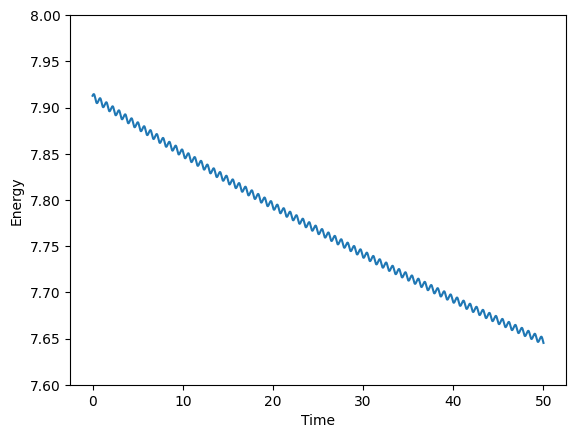

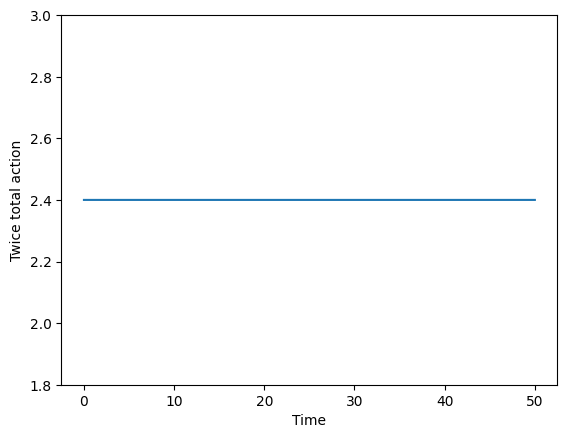

In [6]:
# Implicit Euler
theta_iE = np.zeros((n_steps, N))
I_iE = np.zeros((n_steps, N))

theta_iE[0][:] = theta0
I_iE[0][:] = I0

times = np.zeros(n_steps)
energies = np.zeros(n_steps)
energies[0] = Hamiltonian_function(theta_iE[0,:], I_iE[0,:])
C2s = np.zeros(n_steps)
C2s[0] = 2*np.sum(I_iE[0, :])

eps = 1e-8
max_iter = 50
flag = False
for n in range(0, n_steps-1):

  # First approximation: explicit Euler
  theta_approx = theta_iE[n, :] + t_step * derivative_theta(theta_iE[n, :], I_iE[n, :])
  I_approx = I_iE[n, :] + t_step * derivative_I(theta_iE[n, :], I_iE[n, :])

  error_theta = error_I = 0
  for i in range(N):
    error_theta += (theta_approx[i] - theta_iE[n, i])*(theta_approx[i] - theta_iE[n, i])
    error_I += (I_approx[i] - I_iE[n, i])*(I_approx[i] - I_iE[n, i])
  error = np.sqrt(error_theta) + np.sqrt(error_I)

  iter = 0
  while (error > eps):
      theta_iter = theta_iE[n, :] + t_step * derivative_theta(theta_approx[:], I_approx[:])
      I_iter = I_iE[n, :] + t_step * derivative_I(theta_approx[:], I_approx[:])

      error_theta = error_I = 0
      for i in range(N):
        error_theta += (theta_approx[i] - theta_iter[i])*(theta_approx[i] - theta_iter[i])
        error_I += (I_approx[i] - I_iter[i])*(I_approx[i] - I_iter[i])
      error = np.sqrt(error_theta) + np.sqrt(error_I)

      theta_approx = theta_iter
      I_approx = I_iter
      iter += 1

      if (iter > max_iter):
        flag = True
        break

  if flag:
    print(f'n = {n} did not converge')
    break

  theta_iE[n+1, :] = theta_iter
  I_iE[n+1, :] = I_iter

  times[n+1] = (n+1)*t_step # time
  energies[n+1] = Hamiltonian_function(theta_iE[n+1,:], I_iE[n+1,:])
  C2s[n+1] = 2*np.sum(I_iE[n+1, :])

plt.figure()
plt.plot(times, energies)
plt.ylabel('Energy')
plt.xlabel('Time')
plt.ylim(7.6,8)
plt.show()

plt.figure()
plt.plot(times, C2s)
plt.ylabel('Twice total action')
plt.xlabel('Time')
plt.ylim(1.8,3)
plt.show()

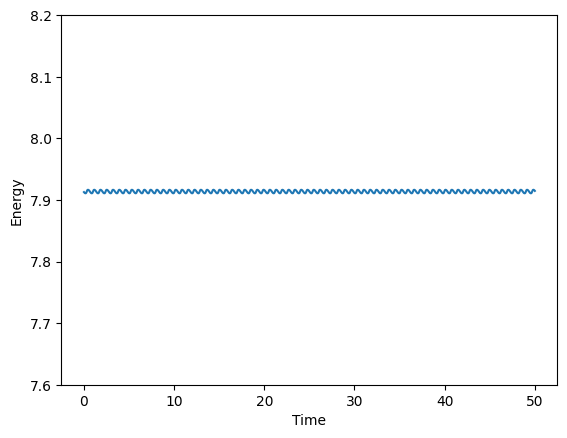

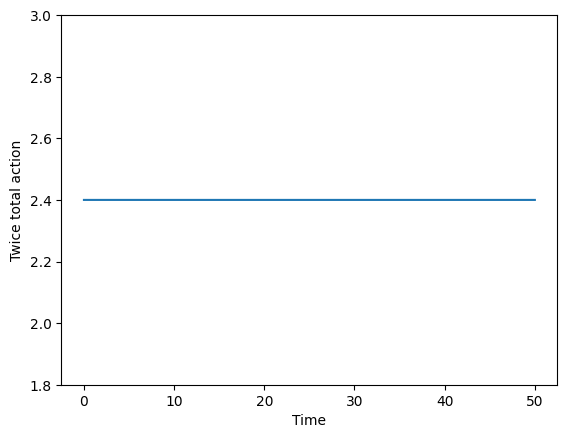

In [7]:
# Symplectic Euler 1
theta_sE1 = np.zeros((n_steps, N))
I_sE1 = np.zeros((n_steps, N))

theta_sE1[0][:] = theta0
I_sE1[0][:] = I0

times = np.zeros(n_steps)
energies = np.zeros(n_steps)
energies[0] = Hamiltonian_function(theta_sE1[0,:], I_sE1[0,:])
C2s = np.zeros(n_steps)
C2s[0] = 2*np.sum(I_sE1[0, :])

eps = 1e-8
max_iter = 50
flag = False
for n in range(0, n_steps-1):

  # First approximation: explicit Euler
  I_approx = I_sE1[n, :] + t_step * derivative_I(theta_sE1[n, :], I_sE1[n, :])

  error_I = 0
  for i in range(N):
    error_I += (I_approx[i] - I_sE1[n, i])*(I_approx[i] - I_sE1[n, i])
  error = np.sqrt(error_I)

  iter = 0
  while (error > eps):
      theta_iter = theta_sE1[n, :] + t_step * derivative_theta(theta_sE1[n, :], I_approx[:])
      I_iter = I_sE1[n, :] + t_step * derivative_I(theta_sE1[n,:], I_approx[:])


      error_I = 0
      for i in range(N):
        error_I += (I_approx[i] - I_iter[i])*(I_approx[i] - I_iter[i])
      error = np.sqrt(error_I)

      I_approx = I_iter
      iter += 1

      if (iter > max_iter):
        flag = True
        break

  if flag:
    print(f'n = {n} did not converge')
    break

  I_sE1[n+1, :] = I_iter
  theta_sE1[n+1, :] = theta_iter

  times[n+1] = (n+1)*t_step # time
  energies[n+1] = Hamiltonian_function(theta_sE1[n+1,:], I_sE1[n+1,:])
  C2s[n+1] = 2*np.sum(I_sE1[n+1, :])


plt.figure()
plt.plot(times, energies)
plt.ylabel('Energy')
plt.xlabel('Time')
plt.ylim(7.6,8.2)
plt.show()

plt.figure()
plt.plot(times, C2s)
plt.ylabel('Twice total action')
plt.xlabel('Time')
plt.ylim(1.8,3)
plt.show()

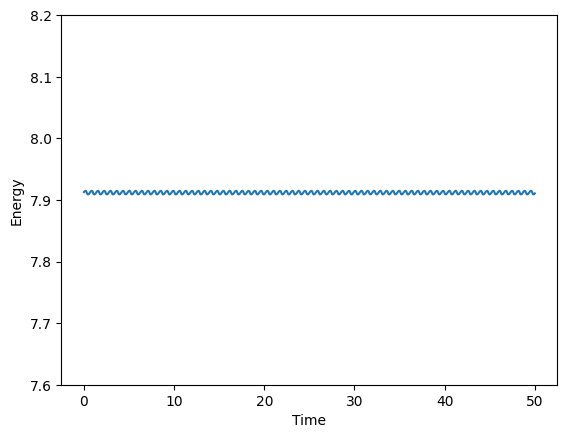

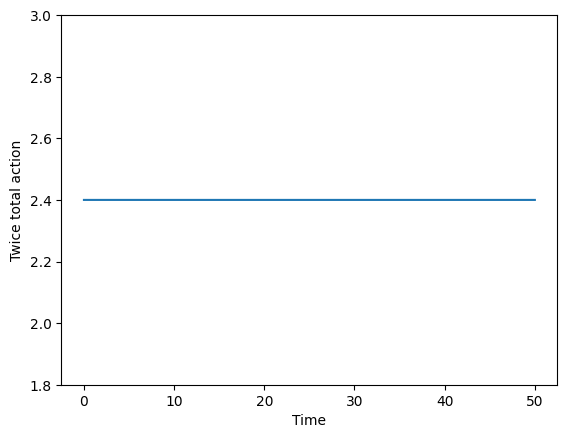

In [8]:
# Symplectic Euler 2
theta_sE2 = np.zeros((n_steps, N))
I_sE2 = np.zeros((n_steps, N))

theta_sE2[0][:] = theta0
I_sE2[0][:] = I0

times = np.zeros(n_steps)
energies = np.zeros(n_steps)
energies[0] = Hamiltonian_function(theta_sE2[0,:], I_sE2[0,:])
C2s = np.zeros(n_steps)
C2s[0] = 2*np.sum(I_sE2[0, :])

eps = 1e-8
max_iter = 50
flag = False
for n in range(0, n_steps-1):

  # First approximation: explicit Euler
  theta_approx = theta_sE2[n, :] + t_step * derivative_theta(theta_sE2[n, :], I_sE2[n, :])

  error_theta = 0
  for i in range(N):
    error_theta += (theta_approx[i] - theta_sE2[n, i])*(theta_approx[i] - theta_sE2[n, i])
  error = np.sqrt(error_theta)

  iter = 0
  while (error > eps):
      theta_iter = theta_sE2[n, :] + t_step * derivative_theta(theta_approx[:], I_sE2[n, :])
      I_iter = I_sE2[n, :] + t_step * derivative_I(theta_approx[:], I_sE2[n, :])

      error_theta = 0
      for i in range(N):
        error_theta += (theta_approx[i] - theta_iter[i])*(theta_approx[i] - theta_iter[i])
      error = np.sqrt(error_theta)

      theta_approx = theta_iter
      iter += 1

      if (iter > max_iter):
        flag = True
        break

  if flag:
    print(f'n = {n} did not converge')
    break

  theta_sE2[n+1, :] = theta_iter
  I_sE2[n+1, :] = I_iter

  times[n+1] = (n+1)*t_step # time
  energies[n+1] = Hamiltonian_function(theta_sE2[n+1,:], I_sE2[n+1,:])
  C2s[n+1] = 2*np.sum(I_sE2[n+1, :])


plt.figure()
plt.plot(times, energies)
plt.ylabel('Energy')
plt.xlabel('Time')
plt.ylim(7.6,8.2)
plt.show()

plt.figure()
plt.plot(times, C2s)
plt.ylabel('Twice total action')
plt.xlabel('Time')
plt.ylim(1.8,3)
plt.show()